In [1]:
include("./src/MPO_common.jl")
using .MPO_common
using JLD2
using BenchmarkTools
using ITensors
using LinearAlgebra
include("./src/iDMRG.jl")
using .iDMRG

# krylovdimmax=2, niter=1 are important inside the loop. In general if they are large, the computation time for each dmrg sweep is longer, and when it finally converges, we don't need it to be large. But for certain gapped phases, we can take them to be large to speed up the convergence and hence reduce the total number of sweeps.

# The algorithm used for noise is the DMRG_SSS modified to the 2-site case.

The output of our idmrg code is similar to Binder, Barthel (PHYSICAL REVIEW B98,235114(2018)). We have periodic cell $[A, \Lambda, B,... B , \Lambda^{-1}]$. We can then use the gauging methods described in Ref.

In [2]:
J1 = 4 * 1.0
Delta = 4 * 0.5
J2 = 4 * 0.2
Ly = 6
uc = Ly

oplist = MPOsum()
for i = 1:Ly
    mpoadd!(oplist, J1 + Delta, (i, "Sz"), (mod1(i + 1, 6), "Sz"))
    mpoadd!(oplist, J1, (i, "Sx"), (mod1(i + 1, 6), "Sx"))
    mpoadd!(oplist, J1, (i, "Sy"), (mod1(i + 1, 6), "Sy"))
    mpoadd!(oplist, J1 + Delta, (i, "Sz"), (mod1(i + 1, 6) + 6, "Sz"))
    mpoadd!(oplist, J1, (i, "Sx"), (mod1(i + 1, 6) + 6, "Sx"))
    mpoadd!(oplist, J1, (i, "Sy"), (mod1(i + 1, 6) + 6, "Sy"))
    mpoadd!(oplist, J1 + Delta, (i, "Sz"), (i + 6, "Sz"))
    mpoadd!(oplist, J1, (i, "Sx"), (i + 6, "Sx"))
    mpoadd!(oplist, J1, (i, "Sy"), (i + 6, "Sy"))

    mpoadd!(oplist, J2, (i, "Sz"), (mod1(i + 2, 6) + 6, "Sz"))
    mpoadd!(oplist, J2, (i, "Sx"), (mod1(i + 2, 6) + 6, "Sx"))
    mpoadd!(oplist, J2, (i, "Sy"), (mod1(i + 2, 6) + 6, "Sy"))
    mpoadd!(oplist, J2, (i, "Sz"), (mod1(i + 1, 6) + 12, "Sz"))
    mpoadd!(oplist, J2, (i, "Sx"), (mod1(i + 1, 6) + 12, "Sx"))
    mpoadd!(oplist, J2, (i, "Sy"), (mod1(i + 1, 6) + 12, "Sy"))
    mpoadd!(oplist, J2, (i, "Sz"), (mod1(i - 1, 6) + 6, "Sz"))
    mpoadd!(oplist, J2, (i, "Sx"), (mod1(i - 1, 6) + 6, "Sx"))
    mpoadd!(oplist, J2, (i, "Sy"), (mod1(i - 1, 6) + 6, "Sy"))
end

sites = siteinds("S=1/2", uc)
iH = op_to_hm_inf(oplist, sites);

leftinds = Vector{Index}(undef, uc)
for i = 1:uc
    leftinds[i] = commonind(iH[mod1(i - 1, uc)], iH[i])
end

resultvalue = iDMRG_init(sites, leftinds)
psis0 = resultvalue[1]
LP10 = resultvalue[2]
RPuc = resultvalue[3]
L_2 = resultvalue[4]
L_4 = resultvalue[5]
println("finish initialization")
flush(stdout)
#End of initialization

psis0, lp10, rpuc, l2, l4 = iDMRG_init(sites, leftinds)
maxdimlist = [50, 100, 250, 250, 200, 200]
sweeplist = [2, 2, 3, 10, 10, 20];
updatedlist = idmrg_general(iH, psis0, lp10, rpuc, l2, l4; maxdim=maxdimlist[1], cutoff=1e-2, nsweeps=1)

for l = 1:3
    println("This is global sweep $l")
    if l <= 3
        dmrgsweeptime = @elapsed updatedlist = idmrg_general(iH, updatedlist[1], updatedlist[2], updatedlist[3], updatedlist[4], updatedlist[5]; nsweeps=1, krylovdimmax=3, niter=1, maxdim=maxdimlist[l], cutoff=1e-10,noise=1e-2)
    end
    for i = 1:sweeplist[l] #We turn on the noise in the first few runs
        println("Sweep $i")
        flush(stdout)
        dmrgsweeptime = @elapsed updatedlist = idmrg_general(iH, updatedlist[1], updatedlist[2], updatedlist[3], updatedlist[4], updatedlist[5]; nsweeps=1, krylovdimmax=2, niter=1, maxdim=maxdimlist[l], cutoff=1e-10)
        flush(stdout)
    end
end


finish initialization
Maximum bond dimension is: 2
Energy is: -2.9073261161463777
Lambda overlap is: 0.8372434609252518
This is global sweep 1
Maximum bond dimension is: 16
Energy is: -1.7987064655521128
Lambda overlap is: 0.9814149324119115
Sweep 1
Maximum bond dimension is: 50
Energy is: -1.7588015496597424
Lambda overlap is: 0.9762713972316766
Sweep 2
Maximum bond dimension is: 50
Energy is: -2.2335139052013964
Lambda overlap is: 0.9900673454133663
This is global sweep 2
Maximum bond dimension is: 100
Energy is: -2.357524605580558
Lambda overlap is: 0.9929384990388126
Sweep 1
Maximum bond dimension is: 100
Energy is: -2.3584101238681114
Lambda overlap is: 0.999433555400534
Sweep 2
Maximum bond dimension is: 100
Energy is: -2.365936329366164
Lambda overlap is: 0.9998245192672424
This is global sweep 3
Maximum bond dimension is: 250
Energy is: -2.3787911478941957
Lambda overlap is: 0.9989845903496786
Sweep 1
Maximum bond dimension is: 250
Energy is: -2.3771015086035825
Lambda overlap 

In [60]:
function idmrg_run(iH, sites;
                   maxdimlist = [50, 100, 250],
                   sweeplist  = [2, 2, 3],
                   init_cutoff = 1e-2,
                   cutoff      = 1e-10,
                   verbose     = true)

    # Build leftinds
    leftinds = [commonind(iH[mod1(i - 1, length(iH))], iH[i]) for i in 1:length(iH)]

    # Initialize and warm-up
    state = iDMRG_init(sites, leftinds)
    verbose && println("finish initialization")
    state = idmrg_general(iH, state...; maxdim=maxdimlist[1], cutoff=init_cutoff, nsweeps=1)

    # Helper: single sweep call
    sweep!(state, l; kwargs...) = idmrg_general(iH, state...; kwargs...)

    # Outer loop
    for l in eachindex(maxdimlist)
        noise = l <= 3 ? 1e-2 : 0.0
        kry   = l <= 3 ? 3    : 2
        verbose && println("== Global sweep $l ==")

        state = sweep!(state, l; nsweeps=1, krylovdimmax=kry, niter=1,
                       maxdim=maxdimlist[l], cutoff=cutoff, noise=noise)

        for i in 1:sweeplist[l]
            verbose && println("  Sweep $i")
            state = sweep!(state, l; nsweeps=1, krylovdimmax=2, niter=1,
                           maxdim=maxdimlist[l], cutoff=cutoff, noise=noise)
        end
    end

    return state
end


idmrg_run (generic function with 1 method)

In [61]:
finalstate = idmrg_run(iH, sites)


finish initialization
Maximum bond dimension is: 1
Energy is: -1.1332361086176748
Lambda overlap is: 1.0000000000000002
== Global sweep 1 ==
Maximum bond dimension is: 7
Energy is: -1.3374135102148152
Lambda overlap is: 0.7059004519123555
  Sweep 1
Maximum bond dimension is: 10
Energy is: -1.0227555729050664
Lambda overlap is: 0.9999972700644065
  Sweep 2
Maximum bond dimension is: 10
Energy is: -1.0227555582350962
Lambda overlap is: 0.9999999998101902
== Global sweep 2 ==
Maximum bond dimension is: 12
Energy is: -1.0279282301611918
Lambda overlap is: 0.9999089743311776
  Sweep 1
Maximum bond dimension is: 16
Energy is: -1.0279576933844616
Lambda overlap is: 0.9999998198828879
  Sweep 2
Maximum bond dimension is: 16
Energy is: -1.0279579598305209
Lambda overlap is: 0.9999999494262666
== Global sweep 3 ==
Maximum bond dimension is: 26
Energy is: -1.0331484715333044
Lambda overlap is: 0.9986972305078196
  Sweep 1
Maximum bond dimension is: 37
Energy is: -1.0332016640407673
Lambda overlap

5-element Vector{Any}:
 MPS
[1] ((dim=2|id=922|"S=1/2,Site,n=1"), (dim=32|id=899|"Link,u"), (dim=52|id=527|"Link,u"))
[2] ((dim=2|id=460|"S=1/2,Site,n=2"), (dim=250|id=647|"Link,v"), (dim=52|id=290|"Link,v"))
[3] ((dim=250|id=883|"Link,v"), (dim=2|id=725|"S=1/2,Site,n=3"), (dim=250|id=647|"Link,v"))
[4] ((dim=128|id=244|"Link,v"), (dim=2|id=59|"S=1/2,Site,n=4"), (dim=250|id=883|"Link,v"))
[5] ((dim=64|id=408|"Link,v"), (dim=2|id=816|"S=1/2,Site,n=5"), (dim=128|id=244|"Link,v"))
[6] ((dim=32|id=577|"Link,v"), (dim=2|id=474|"S=1/2,Site,n=6"), (dim=64|id=408|"Link,v"))

 ITensor ord=3
Dim 1: (dim=32|id=899|"Link,u")
Dim 2: (dim=5|id=184)
Dim 3: (dim=32|id=899|"Link,u")'
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 32×5×32
[:, :, 1] =
     -65.71831624388099 + 4.514962457001182e-15im  …       1.0000000000000042 + 1.0094525801898676e-17im
 -2.4253095461169786e-6 - 1.3552355996146908e-6im      2.0113300745318776e-16 - 4.1892828352726e-16im
  1.5204086022107793e-7 + 3.016888107102189e-7im

In [6]:
Base.summarysize(updatedlist)/1024^3

0.08196596801280975

In [40]:
Ly = 3 # Here it denotes number of true unit-cells
uc = 2 * Ly
Jx = -0.5
Jy = -0.5
Jz = -2.0

-2.0

# Parameters for convergence:
Jx=-0.5
Jy=-0.5
Jz=-2.0
Ly=4
maxdimlist = [50, 100, 150]
sweeplist = [10, 10, 40];
updatedlist = idmrg_general(iH, psis0, lp10, rpuc, l2, l4; maxdim=maxdimlist[1], cutoff=1e-2, nsweeps=1)

for l = 1:3
    println("This is global sweep $l")
    if l <= 3
        for j = 1:2
            dmrgsweeptime = @elapsed updatedlist = idmrg_general(iH, updatedlist[1], updatedlist[2], updatedlist[3], updatedlist[4], updatedlist[5]; nsweeps=1, krylovdimmax=6, niter=3, maxdim=maxdimlist[l], cutoff=1e-10, noise=1e-3)
        end
    end
    for i = 1:sweeplist[l] #We turn on the noise in the first few runs
        println("Sweep $i")
        flush(stdout)
        dmrgsweeptime = @elapsed updatedlist = idmrg_general(iH, updatedlist[1], updatedlist[2], updatedlist[3], updatedlist[4], updatedlist[5]; nsweeps=1, krylovdimmax=6, niter=3, maxdim=maxdimlist[l], cutoff=1e-10)
        flush(stdout)
    end
end

In [51]:
oplist = MPOsum()
for i = 1:Ly
    mpoadd!(oplist, 4 * Jx, (2 * i - 1, "Sx"), (2 * i, "Sx"))
    mpoadd!(oplist, 4 * Jy, (2 * i - 1, "Sy"), (2 * i + 2 * Ly, "Sy"))
end

for i = 1:Ly
    mpoadd!(oplist, 4 * Jz, (2 * i, "Sz"), (mod1(2 * i + 1, 2 * Ly), "Sz"))
end

sites = siteinds("S=1/2", uc)
iH = op_to_hm_inf(oplist, sites);

leftinds = Vector{Index}(undef, uc)
for i = 1:uc
    leftinds[i] = commonind(iH[mod1(i - 1, uc)], iH[i])
end

resultvalue = iDMRG_init(sites, leftinds)
psis0 = resultvalue[1]
LP10 = resultvalue[2]
RPuc = resultvalue[3]
L_2 = resultvalue[4]
L_4 = resultvalue[5]
println("finish initialization")
flush(stdout)
#End of initialization

psis0, lp10, rpuc, l2, l4 = iDMRG_init(sites, leftinds)
maxdimlist = [50, 100, 150, 250, 200, 200]
sweeplist = [20, 20, 40, 10, 10, 20];
updatedlist = idmrg_general(iH, psis0, lp10, rpuc, l2, l4; maxdim=maxdimlist[1], cutoff=1e-2, nsweeps=1)

for l = 1:3
    println("This is global sweep $l")
    if l <= 3
        for j = 1:2
            dmrgsweeptime = @elapsed updatedlist = idmrg_general(iH, updatedlist[1], updatedlist[2], updatedlist[3], updatedlist[4], updatedlist[5]; nsweeps=1, krylovdimmax=6, niter=3, maxdim=maxdimlist[l], cutoff=1e-10, noise=1e-3)
        end
    end
    for i = 1:sweeplist[l] #We turn on the noise in the first few runs
        println("Sweep $i")
        flush(stdout)
        dmrgsweeptime = @elapsed updatedlist = idmrg_general(iH, updatedlist[1], updatedlist[2], updatedlist[3], updatedlist[4], updatedlist[5]; nsweeps=1, krylovdimmax=6, niter=3, maxdim=maxdimlist[l], cutoff=1e-10)
        flush(stdout)
    end
end


finish initialization
Maximum bond dimension is: 1
Energy is: -1.1332361086176748
Lambda overlap is: 1.0000000000000002
This is global sweep 1
Maximum bond dimension is: 4
Energy is: -1.3466122530371873
Lambda overlap is: 0.7058138149712857
Maximum bond dimension is: 6
Energy is: -1.0227554313185578
Lambda overlap is: 0.9999984150507899
Sweep 1
Maximum bond dimension is: 6
Energy is: -1.0227555568009166
Lambda overlap is: 0.9999999855980087
Sweep 2
Maximum bond dimension is: 10
Energy is: -1.0227633399953493
Lambda overlap is: 0.9999999511578255
Sweep 3
Maximum bond dimension is: 16
Energy is: -1.0279566123864103
Lambda overlap is: 0.9999117404084438
Sweep 4
Maximum bond dimension is: 23
Energy is: -1.0280428554565024
Lambda overlap is: 0.9987499334991259
Sweep 5
Maximum bond dimension is: 43
Energy is: -1.0332870999997372
Lambda overlap is: 0.9996532588580971
Sweep 6
Maximum bond dimension is: 49
Energy is: -1.0332107630369787
Lambda overlap is: 0.9996643004428415
Sweep 7
Maximum bond

In [46]:
function dispersion(a1,a2) 
 return sqrt((Jx*cos(2pi* a1) + Jy*cos(2pi* a2) + Jz)^2 + (Jx*sin(2pi* a1) + 
      Jy*sin(2pi* a2))^2)
end


dispersion (generic function with 1 method)

In [43]:
function integrand(alpha2, Ly, alphas)
    # average over alpha1, then divide by 2
    return (sum(a1 -> dispersion(a1, alpha2), alphas) / Ly) / 2
end

function mathematica_expr(Ly)
    alphas = range(1/Ly, stop=1.0, length=Ly)  # 1/Ly, 2/Ly, ..., 1
    f(a2) = integrand(a2, Ly, alphas)
    val, err = quadgk(f, 0.0, 1.0)             # corresponds to NIntegrate[..., {alpha2,0,1}]
    return val, err
end

mathematica_expr (generic function with 1 method)

In [48]:
using QuadGK
mathematica_expr(Ly)


(1.0333819832164692, 1.2205964239342393e-8)

# 1d TFIM

In [66]:
uc = 4

jz = -1.0
hx = -2.0

oplist = MPOsum()
for i = 1:uc
    mpoadd!(oplist, 4 * jz, (i, "Sz"), (i + 1, "Sz"))
    mpoadd!(oplist, 2 * hx, (i, "Sx"))
end

sites = siteinds("S=1/2", uc)
iH = op_to_hm_inf(oplist, sites);
finalstate = idmrg_run(iH, sites; maxdimlist=[50, 100, 250], sweeplist=[2, 2, 3], init_cutoff=1e-2, cutoff=1e-10)

finish initialization
Maximum bond dimension is: 2
Energy is: -2.190473536556369
Lambda overlap is: 0.9911581811989701
== Global sweep 1 ==
Maximum bond dimension is: 5
Energy is: -2.127107545943373
Lambda overlap is: 0.9999950382253208
  Sweep 1
Maximum bond dimension is: 5
Energy is: -2.127088819600594
Lambda overlap is: 0.9999999999617517
  Sweep 2
Maximum bond dimension is: 5
Energy is: -2.127088819582493
Lambda overlap is: 0.9999999999703374
== Global sweep 2 ==
Maximum bond dimension is: 5
Energy is: -2.1270888195844933
Lambda overlap is: 0.9999999999690299
  Sweep 1
Maximum bond dimension is: 5
Energy is: -2.1270888195804005
Lambda overlap is: 0.999999999969027
  Sweep 2
Maximum bond dimension is: 5
Energy is: -2.127088819582344
Lambda overlap is: 0.9999999999703748
== Global sweep 3 ==
Maximum bond dimension is: 5
Energy is: -2.127088819584415
Lambda overlap is: 0.999999999969029
  Sweep 1
Maximum bond dimension is: 5
Energy is: -2.127088819580379
Lambda overlap is: 0.999999999

5-element Vector{Any}:
 MPS
[1] ((dim=2|id=639|"S=1/2,Site,n=1"), (dim=5|id=834|"Link,u"), (dim=5|id=437|"Link,u"))
[2] ((dim=2|id=831|"S=1/2,Site,n=2"), (dim=20|id=168|"Link,v"), (dim=5|id=719|"Link,v"))
[3] ((dim=10|id=449|"Link,v"), (dim=2|id=802|"S=1/2,Site,n=3"), (dim=20|id=168|"Link,v"))
[4] ((dim=5|id=10|"Link,v"), (dim=2|id=455|"S=1/2,Site,n=4"), (dim=10|id=449|"Link,v"))

 ITensor ord=3
Dim 1: (dim=5|id=834|"Link,u")
Dim 2: (dim=3|id=941)
Dim 3: (dim=5|id=834|"Link,u")'
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 5×3×5
[:, :, 1] =
      -93.46018392338304 + 0.0im  …       1.0000000000000095 + 0.0im
 -3.9951185216781985e-14 + 0.0im      1.2409087075121646e-16 + 0.0im
  2.8617071197392814e-14 + 0.0im      -4.890423417399574e-17 + 0.0im
    0.017477003030914363 + 0.0im     -1.4559271688503936e-16 + 0.0im
 -1.0722796956440392e-14 + 0.0im     -3.6309940095483954e-16 + 0.0im

[:, :, 2] =
  -3.097490049080732e-14 + 0.0im  …  1.1495261350267808e-16 + 0.0im
      -89.8645593689313

In [73]:
# dispersion
ε(k, J, g) = 2J * sqrt(1 + g^2 - 2g*cos(k))

J = 1.0
g = 2.0

# e.g. integrate over the 1D Brillouin zone [0, π]
val = quadgk(k -> ε(k, J, g), 0, π; rtol=1e-10)[1]

# if you want the Brillouin-zone average:
avg = val / (2π)
println("BZ average = $avg")

BZ average = 2.12708881994673


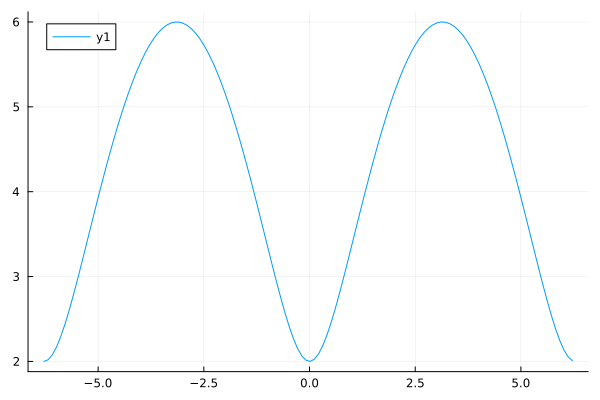

In [71]:
using Plots 
k=-2pi:0.1:2pi
plot(k,ε.(k, J, g))

In [74]:
2.12708881994673-2.1270888195824185

3.643116919249678e-10